
В данном задании стоят следующие задачи:

1. Ознакомиться с датасетом образцов эмоциональной речи

    **Toronto emotional speech set (TESS)**:

    https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF

    Ссылка для загрузки данных: https://storage.googleapis.com/datasets_ai/Base/12_audio/dataverse_files.zip

2. Разобрать датасет;
3. Подготовить и разделить данные на обучающие и тестовые;
4. Разработать классификатор, показывающий на тесте точность распознавания эмоции не менее 98%;
5. Ознакомиться с другим датасетом похожего содержания

    **Surrey Audio-Visual Expressed Emotion (SAVEE)**:

    https://www.kaggle.com/ejlok1/surrey-audiovisual-expressed-emotion-savee

    Ссылка для загрузки данных: https://storage.googleapis.com/datasets_ai/Base/12_audio/archive.zip

6. Прогнать обученный классификатор на файлах из датасета **SAVEE** по нашему выбору;
7. Сделать выводы.

In [1]:
# Массивы
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Связь с google диском
from google.colab import drive

# Загрузка из google облака
import gdown

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

# Работа с папками и файлами
import os

# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Сохранение и загрузка структур данных Python
import pickle

# Параметризация аудио
import librosa

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [2]:
# Загрузка датасета из облака
gdown.download('https://storage.googleapis.com/datasets_ai/Base/12_audio/dataverse_files.zip', None, quiet=True)

'dataverse_files.zip'

In [3]:
# Распаковка архива на локальный диск colab
!unzip -qo dataverse_files.zip -d /content/emotions


In [4]:
# удалим лишний текстовый файл из директории
!rm -rf '/content/emotions/MANIFEST.TXT'

In [5]:
# Проверка содержимого 
!ls /content/emotions/OAF_back_angry.wav

/content/emotions/OAF_back_angry.wav


In [6]:
# выделим категории в датасете
CLASS_LIST=['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']

In [7]:
FILE_DIR = '/content/emotions/'                     # Папка с файлами датасета
CLASS_LIST.sort()                         # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)             # Количество классов
CLASS_FILES = 400                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 90               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
DURATION_SEC = 30                         # Анализируемая длительность аудиосигнала
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

In [8]:
# Проверка списка классов
print(CLASS_LIST)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']


In [9]:
emotions=len(os.listdir(FILE_DIR))
emotions

2800

In [10]:
# Загрузка датасета. Добавляются имена классов и соответствующие имена файлов
class_angry = []
class_disgust = []
class_fear = []
class_happy = []
class_neutral = []
class_ps = []
class_sad = []

#for file_name in FILE_DIR:
for file_name in os.listdir(FILE_DIR):
    # Выделение имени класса из имени файла
  #if file_name.str.contains("angry"):
  if "angry" in file_name:
      class_angry.append(file_name)
  if "disgust" in file_name:
      class_disgust.append(file_name)
  if "fear" in file_name:
      class_fear.append(file_name)
  if "happy" in file_name:
      class_happy.append(file_name)
  if "neutral" in file_name:
      class_neutral.append(file_name)
  if "ps" in file_name:
      class_ps.append(file_name)
  if "sad" in file_name:
      class_sad.append(file_name)


In [11]:
#Функция параметризации аудио
def get_features(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности (по умолчанию 12 баков цветности)
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел кепстральные коэффициенты (по умолчанию 20)
  
  rmse = np.mean(librosa.feature.rms(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) #среднее спектральныго центроида
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) #среднее ширины полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #среднее спектрального спада частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #среднее частота пересечения нуля звукового временного ряда
  
  
  #Добавляем все параметры в один список
  out = [] # создаем пустой список
  out.append(rmse) #  добавляем среднеквадратичную амплитуду
  out.append(spec_cent) #добавляем спектральный центроид
  out.append(spec_bw) # добавляем ширину полосы частот
  out.append(rolloff) # добавляем спектральный спад частоты
  out.append(zcr) # добавляем пересечение нуля
  
  #добавляем среднее всех Мел спектральных коэффициентов (20 значений)
  for e in mfcc:
    out.append(np.mean(e))

  #добавляем среднее всех Частот цветности (12 значений)
  for e in chroma_stft:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список размерностью (37,)
  return out

In [12]:
X_train = []

#Проходим по файлам папки
for file_name in os.listdir(FILE_DIR):
#Загружаем в y аудиосигнал
#Используем первые 30 секунд аудио
  y, sr = librosa.load( '/content/emotions/' + file_name, mono=True, duration=30) #y - массив данных временного ряда аудио, sr - частота дискретизации временного ряда
    #Превращаем сигнал в параметризованные данные
  out = get_features(y, sr)
    
    #Добавляем строку в X_train
  X_train.append(out)

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)

In [15]:
len(X_train[0])

37

In [19]:
Y_train=[]
for file_name in os.listdir(FILE_DIR):
    # Выделение имени класса из имени файла
  #if file_name.str.contains("angry"):
  if "angry" in file_name:
      Y_train.append(0)
  if "disgust" in file_name:
      Y_train.append(1)
  if "fear" in file_name:
      Y_train.append(2)
  if "happy" in file_name:
      Y_train.append(3)
  if "neutral" in file_name:
      Y_train.append(4)
  if "ps" in file_name:
      Y_train.append(5)
  if "sad" in file_name:
      Y_train.append(6)
#Превращаем ответы  в numpy массивы
Y_train = np.array(Y_train)

In [21]:
#Создаём backup обучающей выборки
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [24]:
Y_train= np.array(Y_train.reshape(-1, 1))

In [25]:
#Выводим размеры обучающей выборки
print(X_train.shape)
print(Y_train.shape)
#print(y_train_class.shape)

(2800, 37)
(2800, 1)


In [26]:
Y_train

array([[2],
       [1],
       [6],
       ...,
       [3],
       [3],
       [1]])

In [27]:
#Создаём scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
#Номируем X_train
X_train = scaler.fit_transform(X_train)

In [28]:
#Разделяем выборку на обучающую и проверочную
#Для проверочной используем 10% примеров
#Так как база маленькая
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.15)

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2380, 37)
(420, 37)
(2380, 1)
(420, 1)


##Создаём нейронку

Epoch 1/20
119/119 [==============================] - 1s 3ms/step - loss: 1.9895 - accuracy: 0.2286 - val_loss: 1.6735 - val_accuracy: 0.3595
Epoch 2/20
119/119 [==============================] - 0s 2ms/step - loss: 1.4181 - accuracy: 0.5202 - val_loss: 1.1945 - val_accuracy: 0.6762
Epoch 3/20
119/119 [==============================] - 0s 2ms/step - loss: 1.0255 - accuracy: 0.7630 - val_loss: 0.8637 - val_accuracy: 0.8571
Epoch 4/20
119/119 [==============================] - 0s 2ms/step - loss: 0.7611 - accuracy: 0.8559 - val_loss: 0.6413 - val_accuracy: 0.8952
Epoch 5/20
119/119 [==============================] - 0s 4ms/step - loss: 0.5795 - accuracy: 0.8945 - val_loss: 0.4898 - val_accuracy: 0.9071
Epoch 6/20
119/119 [==============================] - 0s 2ms/step - loss: 0.4527 - accuracy: 0.9193 - val_loss: 0.3821 - val_accuracy: 0.9357
Epoch 7/20
119/119 [==============================] - 0s 2ms/step - loss: 0.3627 - accuracy: 0.9311 - val_loss: 0.3082 - val_accuracy: 0.9476
Epoch 

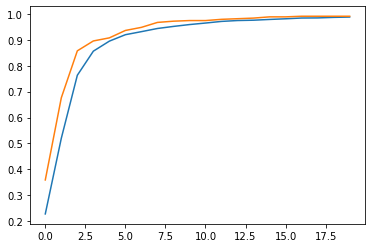

In [33]:
#Указываем, какие индексы данных во входных векторах брать для обучения
#Делаем это для того, чтобы можно было экспериментировать
#И обучать не на всех колонках данных, а на части
indexes = range(0,37)

#Создаём полносвязанную сеть 
model = Sequential()
model.add(Dense(64, activation='elu', input_shape=(len(indexes),)))
#model.add(Dense(128, activation='elu'))
#model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
#В конце количество нейронов равно количеству классов и softmax
model.add(Dense(CLASS_COUNT, activation='softmax'))

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=20,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Итак, мы обучили модель, получили точность на проверочной выборке 99%, протестируем теперь нашу модель на новых данных

In [117]:
# Загрузка датасета из облака
gdown.download('https://storage.googleapis.com/datasets_ai/Base/12_audio/archive.zip', None, quiet=True)

'archive.zip'

In [118]:
# Распаковка архива на локальный диск colab
!unzip -qo archive.zip -d /content/archive

In [119]:
# Проверка содержимого 
!ls /content/archive/ALL/DC_a01.wav

/content/archive/ALL/DC_a01.wav


в новом датасете у нас всего 6 эмоций: anger, disgust, fear, happiness, sadness and surprise.

а в изначальном у нас их было 7: anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral

In [120]:
# выделим категории в датасете
CLASS_LIST_NEW=['angry', 'disgust', 'fear', 'happy', 'ps', 'sad', 'neutral']
# выделим категории в датасете
DURATION_SEC_NEW = 30   
CLASS_LIST_COUNT_NEW=len(CLASS_LIST_NEW)
FILE_DIR_NEW = '/content/archive/ALL/' 

In [121]:
archive=len(os.listdir(FILE_DIR_NEW))
archive

480

In [122]:
X_archive = []

#Проходим по файлам папки
for file_name in os.listdir(FILE_DIR_NEW):
#Загружаем в y аудиосигнал
#Используем первые 30 секунд аудио
  y, sr = librosa.load( '/content/archive/ALL/' + file_name, mono=True, duration=30) #y - массив данных временного ряда аудио, sr - частота дискретизации временного ряда
    #Превращаем сигнал в параметризованные данные
  out = get_features(y, sr)
    
    #Добавляем строку в X_train
  X_archive.append(out)

#Превращаем обучающую выборку на numpy массивы
X_archive = np.array(X_archive)

In [123]:
len(X_archive[0])

37

In [124]:
Y_archive=[]
for file_name in os.listdir(FILE_DIR_NEW):
    # Выделение имени класса из имени файла
  #if file_name.str.contains("angry"):
  if "_a" in file_name:
      Y_archive.append(0)
  if "_d" in file_name:
      Y_archive.append(1)
  if "_f" in file_name:
      Y_archive.append(2)
  if "_h" in file_name:
      Y_archive.append(3)
  if "_n" in file_name:
      Y_archive.append(4)
  if "_su" in file_name:
      Y_archive.append(5)
  if "_sa" in file_name:
      Y_archive.append(6)
#Превращаем ответы  в numpy массивы
Y_archive = np.array(Y_archive)

In [125]:
Y_archive

array([3, 2, 4, 4, 5, 4, 0, 6, 6, 5, 6, 2, 6, 2, 3, 4, 5, 3, 6, 4, 6, 4,
       0, 4, 1, 3, 4, 1, 3, 6, 4, 1, 6, 4, 3, 6, 0, 4, 1, 5, 2, 0, 6, 6,
       4, 6, 0, 0, 0, 1, 5, 4, 2, 4, 5, 2, 5, 4, 5, 1, 0, 3, 4, 2, 2, 6,
       6, 4, 3, 2, 0, 4, 1, 0, 4, 6, 2, 2, 6, 1, 3, 6, 1, 1, 4, 2, 4, 3,
       1, 4, 1, 4, 4, 6, 4, 0, 3, 2, 6, 1, 4, 5, 2, 3, 1, 5, 0, 0, 4, 3,
       3, 0, 0, 4, 4, 2, 4, 5, 5, 3, 3, 6, 3, 0, 1, 5, 0, 6, 3, 2, 3, 4,
       4, 6, 2, 3, 4, 1, 2, 3, 3, 0, 5, 1, 0, 4, 4, 1, 1, 3, 6, 4, 2, 1,
       5, 4, 1, 0, 0, 0, 4, 3, 4, 1, 2, 6, 4, 4, 1, 3, 1, 2, 1, 4, 6, 6,
       0, 5, 0, 3, 1, 0, 5, 4, 4, 0, 3, 4, 4, 1, 6, 0, 2, 5, 6, 2, 1, 2,
       2, 2, 3, 4, 2, 4, 5, 0, 5, 4, 1, 5, 2, 6, 2, 0, 2, 4, 1, 2, 4, 4,
       3, 0, 5, 4, 4, 5, 4, 1, 2, 6, 3, 3, 1, 2, 2, 4, 3, 0, 4, 3, 5, 4,
       2, 0, 4, 3, 1, 5, 5, 6, 2, 3, 5, 6, 6, 1, 4, 1, 1, 3, 1, 3, 4, 6,
       3, 4, 2, 0, 0, 3, 3, 4, 0, 4, 4, 1, 3, 4, 3, 5, 6, 6, 6, 1, 6, 2,
       1, 5, 2, 4, 4, 5, 4, 0, 4, 3, 6, 6, 2, 5, 3,

In [126]:
#Создаём backup новой выборки
X_new_backup = X_archive.copy()
Y_new_backup = Y_archive.copy()

In [127]:
Y_archive= np.array(Y_archive.reshape(-1, 1))

In [128]:
#Выводим размеры обучающей выборки
print(X_archive.shape)
print(Y_archive.shape)
#print(y_train_class.shape)

(480, 37)
(480, 1)


In [129]:
#Создаём scaler экземпляр класса StandardScaler() для нормировки новых  данных
scaler = StandardScaler()
#Номируем X_archive
X_archive = scaler.fit_transform(X_archive)

In [130]:
#Делаем predict
y = model.predict(X_archive)

In [131]:
y[0]

array([0.07927705, 0.00082489, 0.00203002, 0.34459013, 0.00673529,
       0.55459255, 0.01195012], dtype=float32)

In [132]:
# переведем ответы модели в более удобный формат
answers=[]
for i in y:
  answers.append(np.argmax(i))


In [133]:
answers = np.array(answers)

In [134]:
# ответы модели
answers[0:5]

array([5, 5, 6, 1, 0])

In [135]:
# правильные ответы
Y_archive[0:5]

array([[3],
       [2],
       [4],
       [4],
       [5]])

In [136]:
Y_archive=Y_archive.reshape(1, Y_archive.shape[0]*Y_archive.shape[1])

In [113]:
Y_archive[0]

array([3, 2, 4, 4, 5, 4, 0, 6, 6, 5, 6, 2, 6, 2, 3, 4, 5, 3, 6, 4, 6, 4,
       0, 4, 1, 3, 4, 1, 3, 6, 4, 1, 6, 4, 3, 6, 0, 4, 1, 5, 2, 0, 6, 6,
       4, 6, 0, 0, 0, 1, 5, 4, 2, 4, 5, 2, 5, 4, 5, 1, 0, 3, 4, 2, 2, 6,
       6, 4, 3, 2, 0, 4, 1, 0, 4, 6, 2, 2, 6, 1, 3, 6, 1, 1, 4, 2, 4, 3,
       1, 4, 1, 4, 4, 6, 4, 0, 3, 2, 6, 1, 4, 5, 2, 3, 1, 5, 0, 0, 4, 3,
       3, 0, 0, 4, 4, 2, 4, 5, 5, 3, 3, 6, 3, 0, 1, 5, 0, 6, 3, 2, 3, 4,
       4, 6, 2, 3, 4, 1, 2, 3, 3, 0, 5, 1, 0, 4, 4, 1, 1, 3, 6, 4, 2, 1,
       5, 4, 1, 0, 0, 0, 4, 3, 4, 1, 2, 6, 4, 4, 1, 3, 1, 2, 1, 4, 6, 6,
       0, 5, 0, 3, 1, 0, 5, 4, 4, 0, 3, 4, 4, 1, 6, 0, 2, 5, 6, 2, 1, 2,
       2, 2, 3, 4, 2, 4, 5, 0, 5, 4, 1, 5, 2, 6, 2, 0, 2, 4, 1, 2, 4, 4,
       3, 0, 5, 4, 4, 5, 4, 1, 2, 6, 3, 3, 1, 2, 2, 4, 3, 0, 4, 3, 5, 4,
       2, 0, 4, 3, 1, 5, 5, 6, 2, 3, 5, 6, 6, 1, 4, 1, 1, 3, 1, 3, 4, 6,
       3, 4, 2, 0, 0, 3, 3, 4, 0, 4, 4, 1, 3, 4, 3, 5, 6, 6, 6, 1, 6, 2,
       1, 5, 2, 4, 4, 5, 4, 0, 4, 3, 6, 6, 2, 5, 3,

In [137]:
from sklearn.metrics import accuracy_score

In [138]:
accuracy_archive=accuracy_score(Y_archive[0], answers, normalize=True)

In [139]:
# Точность модели на новых данных
accuracy_archive

0.13541666666666666

## Выводы

Точность модели на новой базе файлов очень низкая. Я неоднократно проверила код и не нашла никакой ошибки, данные одинаково обрабатываются как на изначальной базе файлов, так и на новой, приводятся к одинаковому формату. Данные классифицированы на одни и те же категории.

Но на изначальной выборке модель показывает точность 99%, а на новой - всего лишь 13...

Вероятнее всего это связано с тем, что в изначальной выборке, на которой обучалась модель, аудиофайлы - записи женских голосов, а в новой - аудиозаписи мужских голосов...

Видимо, из-за этого модель не может их точно классифицировать.
